# Introduction:

In [40]:
!nvidia-smi

Sun Mar  2 23:09:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             32W /   70W |    3431MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [41]:
!pip install -q gdown inference-gpu
!pip install -q git+https://github.com/roboflow/sports.git

  Preparing metadata (setup.py) ... done


In [42]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /kaggle/working/0bfacc_0.mp4
100%|███████████████████████████████████████| 19.9M/19.9M [00:00<00:00, 236MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: /kaggle/working/2e57b9_0.mp4
100%|███████████████████████████████████████| 21.1M/21.1M [00:00<00:00, 263MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: /kaggle/working/08fd33_0.mp4
100%|███████████████████████████████████████| 19.9M/19.9M [00:00<00:00, 217MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
To: /kaggle/working/573e61_0.mp4
100%|███████████████████████████████████████| 18.9M/18.9M [00:00<00:00, 209MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /kaggle/working/121364_0.mp4
100%|███████████████████████████████████████| 17.2M/17.2M [00:00<00:00, 225MB/s]


In [43]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]" 
# Telling ONX which execution provider to use [in this case its CUDA].

In [44]:
import io
import sys
import cv2
import umap
import torch
import numpy as np
import supervision as sv

from inference import get_model
from kaggle_secrets import UserSecretsClient
from google.colab import userdata 
from tqdm import tqdm
from more_itertools import chunked # To make batches of data
from sklearn.cluster import KMeans
from typing import Optional
from transformers import AutoProcessor, SiglipVisionModel
from sports.common.team import TeamClassifier
from sports.common.view import ViewTransformer
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

In [45]:
SOURCE_VIDEO_PATH = "/kaggle/working/121364_0.mp4"
TARGET_VIDEO_PATH = "/kaggle/working/121364_0_result.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
STRIDE = 30

In [46]:
user_secrets = UserSecretsClient()
ROBOFLOW_API_KEY = user_secrets.get_secret("Roboflow")

# Object Detection & Team Classification:


In [47]:
PLAYER_DETECTION_MODEL_ID = "football-detection-ysgxf/3"
PLAYER_DETECTION_MODEL = get_model(
    model_id=PLAYER_DETECTION_MODEL_ID, 
    api_key=ROBOFLOW_API_KEY
)

In [48]:
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [49]:
def extract_crops(source_video_path: str):
    # Stride to skip every 29 frames and give us the 30th one
    frame_generator2 = sv.get_video_frames_generator(source_path=source_video_path, stride=STRIDE)
    crops = []
    for frame_sample in tqdm(frame_generator2, desc='collecting crops'):
        result = PLAYER_DETECTION_MODEL.infer(frame_sample, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        crops += [
            sv.crop_image(frame_sample, xyxy) 
            for xyxy 
            in detections.xyxy
        ]
    return crops

collecting crops: 25it [00:11,  2.24it/s]


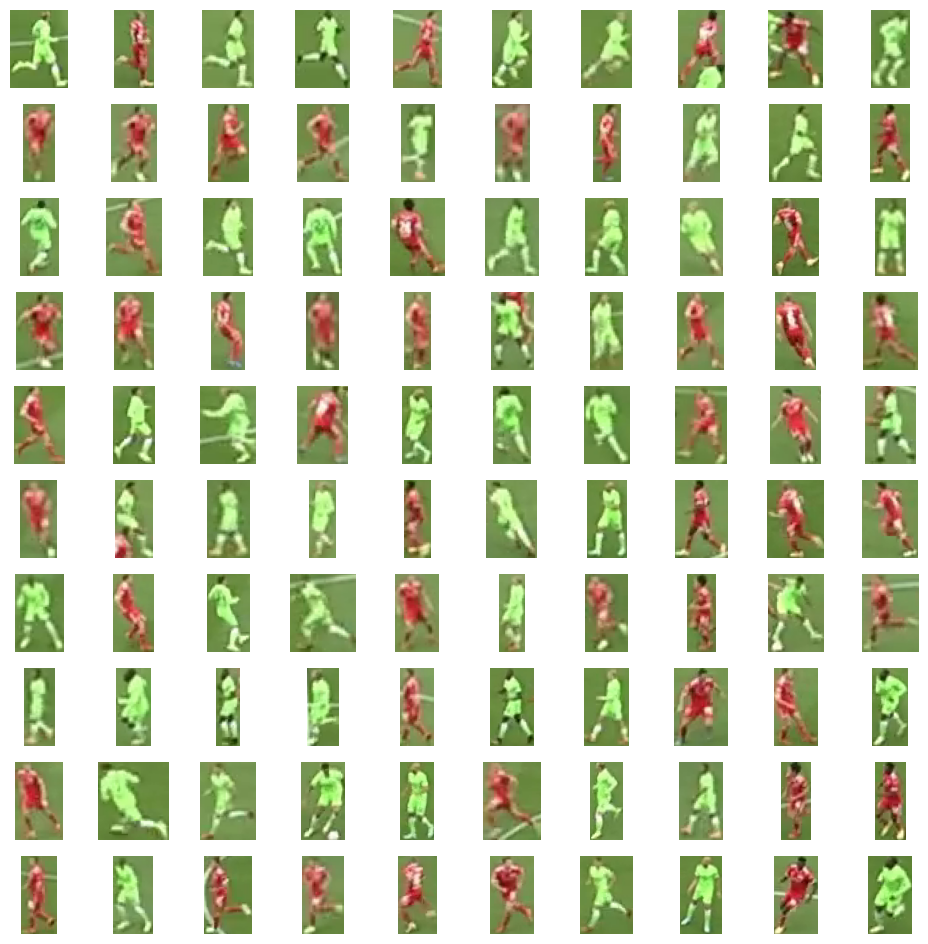

In [50]:
crops = extract_crops(SOURCE_VIDEO_PATH)
len('Number of crops:'+str(crops))
sv.plot_images_grid(crops[:100], grid_size=[10,10])

In [51]:
BATCH_SIZE = 32
# Converting from nump arrays (used by OpenCV which is used by Supervision) to pillow for SigLIP Model.
crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad(): # So model does not find gradient(not in training mode).
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data) # Last layer has higher dimensions so avg out to get the 768 vector.
data.shape

embedding extraction: 15it [00:07,  2.04it/s]


(478, 768)

In [52]:
REDUCER = umap.UMAP(n_components=3) # Reduce to 3D Space.
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [53]:
projections = REDUCER.fit_transform(data)
projections.shape

(478, 3)

In [54]:
clusters = CLUSTERING_MODEL.fit_predict(projections)
clusters[:]

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,

In [55]:
team_0 = [
    crop for crop, cluster
    in zip(crops, clusters)
    if cluster == 0
]
team_1 = [
    crop for crop, cluster
    in zip(crops, clusters)
    if cluster == 1
]

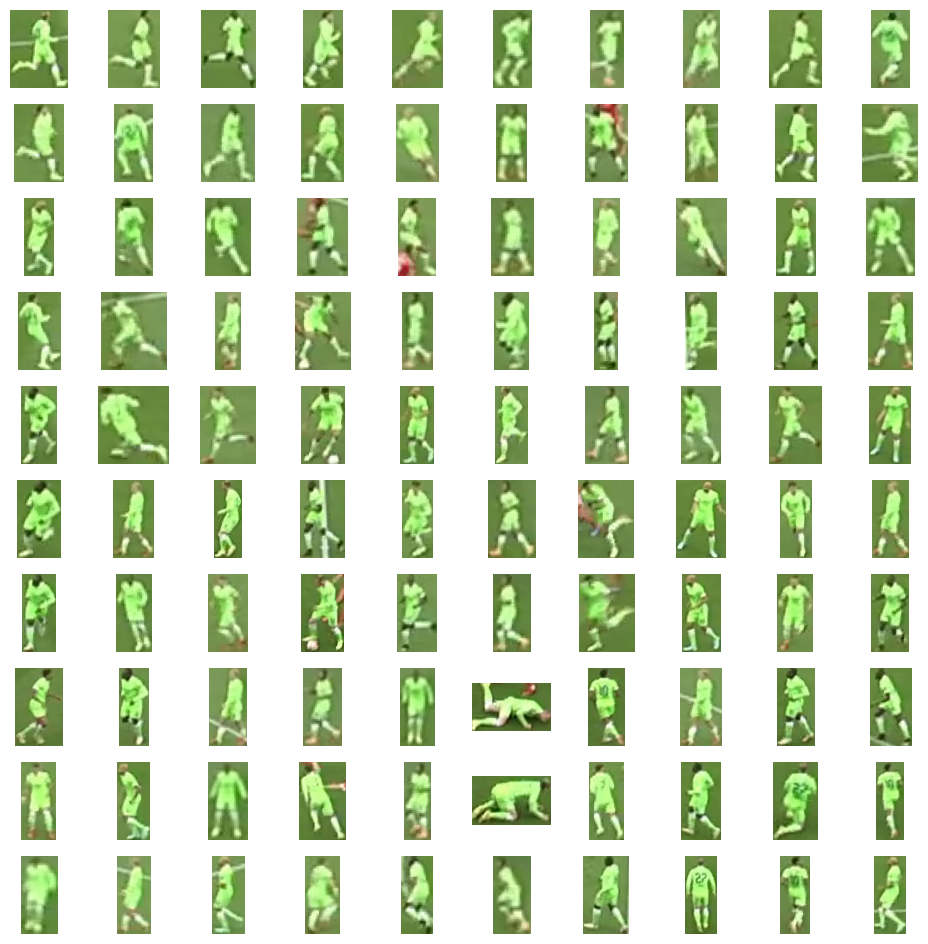

In [56]:
sv.plot_images_grid(team_0[:100], grid_size=[10,10])

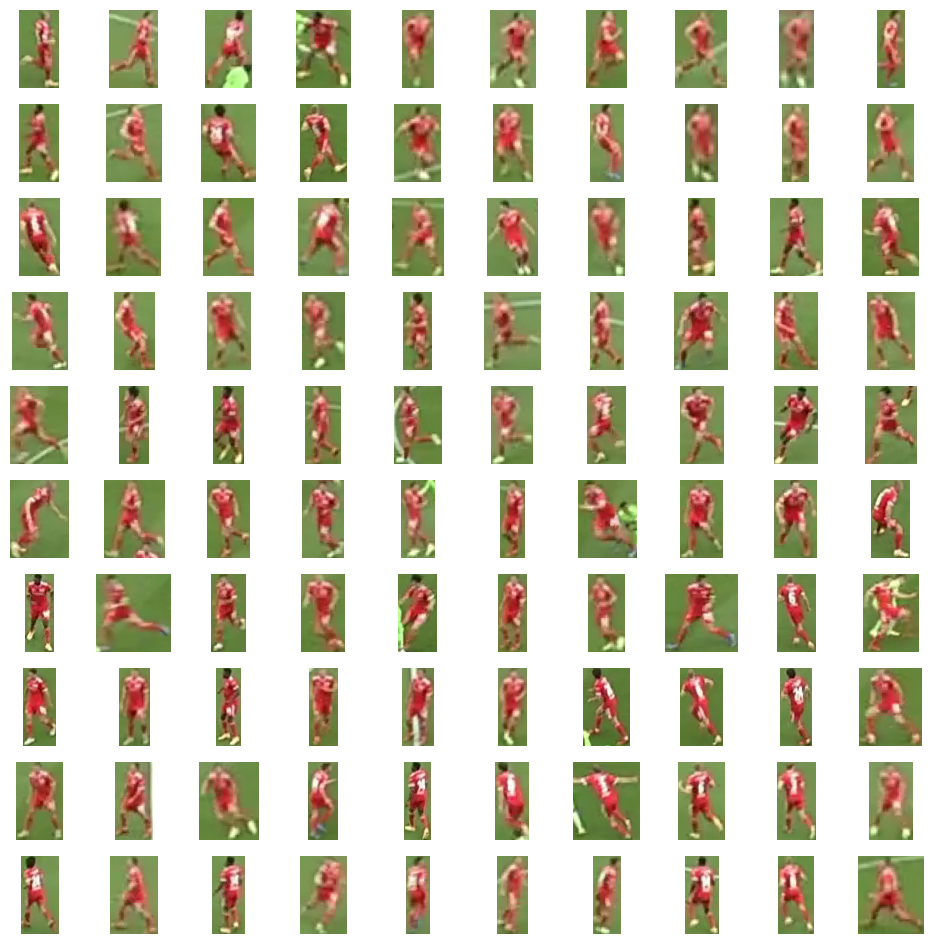

In [57]:
sv.plot_images_grid(team_1[:100], grid_size=[10,10])

In [58]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [00:11,  2.16it/s]
Embedding extraction: 18it [00:08,  2.03it/s]


In [59]:
def resolve_goalkeepers_team_id(players: sv.Detections,goalkeepers: sv.Detections) -> np.ndarray:
    
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        # See the distance between the two teams' centroid
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

Embedding extraction: 1it [00:00,  3.53it/s]


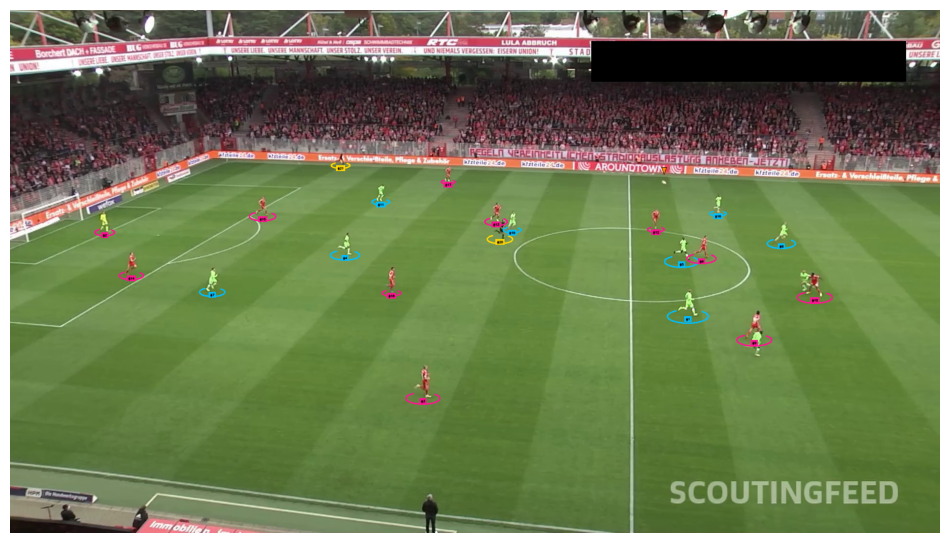

In [60]:
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00']),
    base = 10, 
    height= 15,
    outline_thickness=1
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_scale=0.2,
    text_thickness=1,
    text_padding=3,
    text_position=sv.Position.BOTTOM_CENTER
)

tracker = sv.ByteTrack()
tracker.reset()

# Allows us to loop over frames of the video
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH) 
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
other_detections = detections[detections.class_id != BALL_ID]

# Formatting detections:
# Increasing Ball Bounding box so traingle appears higher
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
# Adding Non-max Supressions to remove overlapping detections, regardless of whether they are from the same class or not
other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
# other_detections.class_id = other_detections.class_id - 1
other_detections = tracker.update_with_detections(detections=other_detections)

goalkeepers_detections = other_detections[other_detections.class_id == GOALKEEPER_ID]
players_detections = other_detections[other_detections.class_id == PLAYER_ID]
referees_detections = other_detections[other_detections.class_id == REFEREE_ID]


player_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(player_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

other_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in other_detections.tracker_id
]
other_detections.class_id = other_detections.class_id.astype(int)
annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=other_detections)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=other_detections,
    labels=labels)

sv.plot_image(annotated_frame)

  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
  0%|          | 1/750 [00:00<09:00,  1.39it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.49it/s]
  0%|          | 2/750 [00:01<08:34,  1.45it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.62it/s]
  0%|          | 3/750 [00:02<08:22,  1.49it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.61it/s]
  1%|          | 4/750 [00:02<08:16,  1.50it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.49it/s]
  1%|          | 5/750 [00:03<08:15,  1.50it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.48it/s]
  1%|          | 6/750 [00:04<08:16,  1.50it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.51it/s]
  1%|          | 7/750 [00:04<08:13,  1.51it/s]
Embedding extraction: 

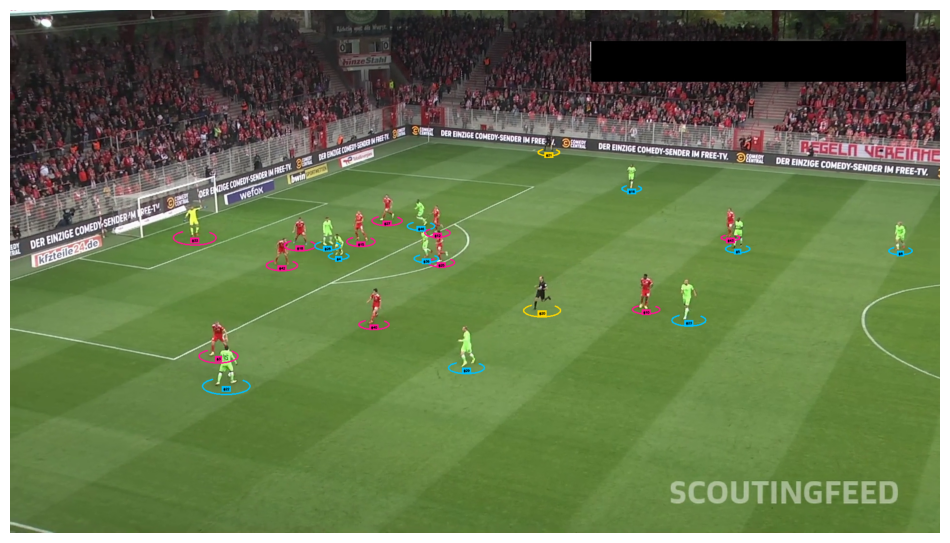

In [61]:
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00']),
    base = 15, 
    height= 17,
    outline_thickness=0
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_scale=0.2,
    text_thickness=1,
    text_padding=3,
    text_position=sv.Position.BOTTOM_CENTER
)

tracker = sv.ByteTrack()
tracker.reset()

# Allows us to loop over frames of the video
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Keeping the same video attributes as the input video
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        
        ball_detections = detections[detections.class_id == BALL_ID]
        other_detections = detections[detections.class_id != BALL_ID]
        
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
        other_detections = tracker.update_with_detections(detections=other_detections)
        
        goalkeepers_detections = other_detections[other_detections.class_id == GOALKEEPER_ID]
        players_detections = other_detections[other_detections.class_id == PLAYER_ID]
        referees_detections = other_detections[other_detections.class_id == REFEREE_ID]
        
        
        player_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(player_crops)
        
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
            players_detections, goalkeepers_detections
        )
        
        referees_detections.class_id -= 1
        
        other_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])
        
        other_detections.class_id = other_detections.class_id.astype(int)
        
        labels = [
            f"#{tracker_id}"
            for tracker_id
            in other_detections.tracker_id
        ]
        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=other_detections)
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame,
            detections=ball_detections)
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=other_detections,
            labels=labels)
        video_sink.write_frame(annotated_frame)

sv.plot_image(annotated_frame)

In [62]:
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi-jufj9/1"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

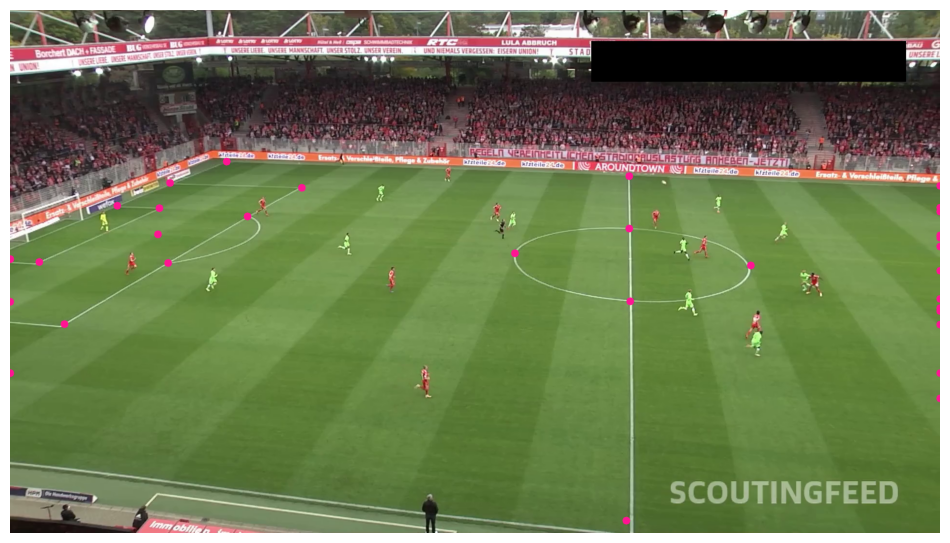

In [63]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

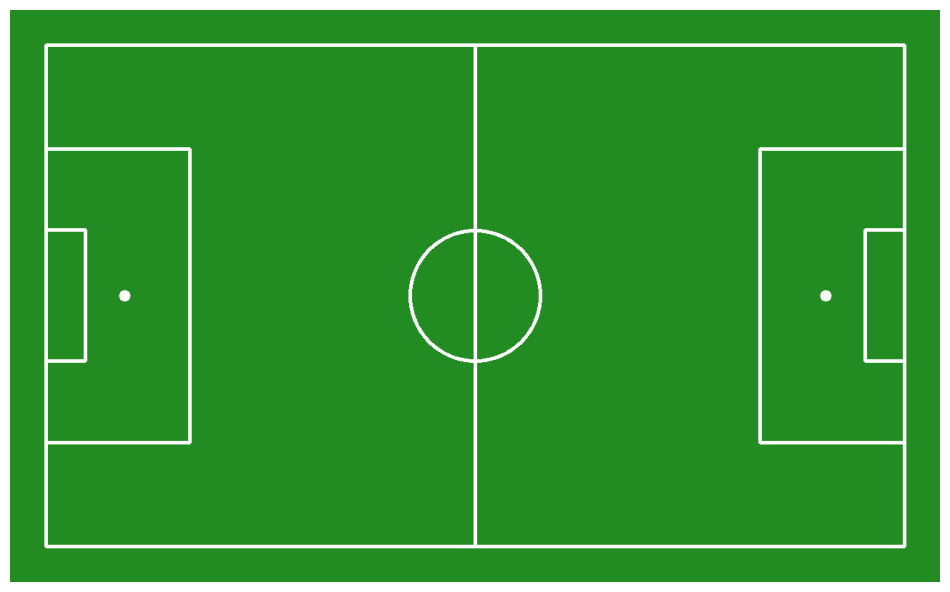

In [64]:
CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

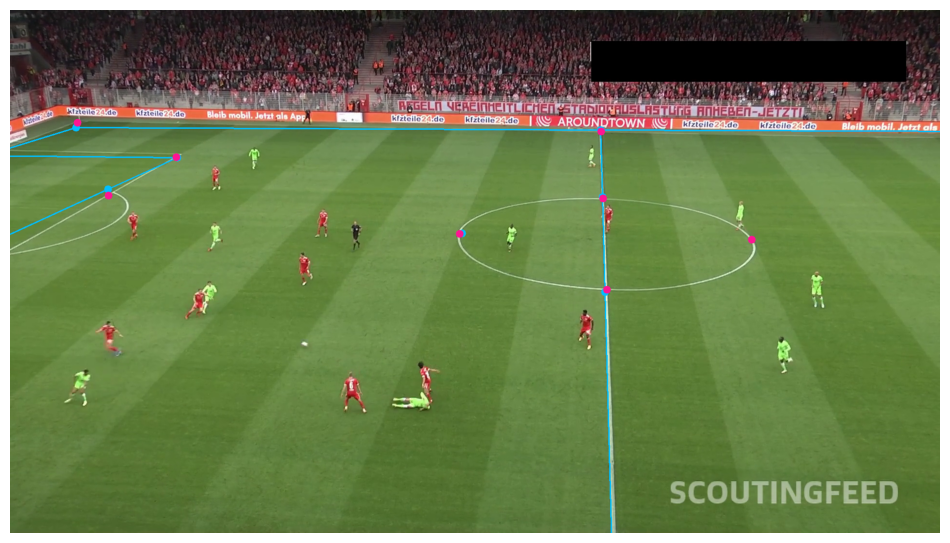

In [65]:
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [66]:
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [00:11,  2.24it/s]
Embedding extraction: 18it [00:08,  2.11it/s]


In [67]:
def draw_pitch_voronoi_diagram_2(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws a Voronoi diagram on a soccer pitch representing the control areas of two
    teams with smooth color transitions.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        team_1_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 1.
        team_2_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 2.
        team_1_color (sv.Color, optional): Color representing the control area of
            team 1. Defaults to sv.Color.RED.
        team_2_color (sv.Color, optional): Color representing the control area of
            team 2. Defaults to sv.Color.WHITE.
        opacity (float, optional): Opacity of the Voronoi diagram overlay.
            Defaults to 0.5.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw the
            Voronoi diagram on. If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with the Voronoi diagram overlay.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((
        scaled_width + 2 * padding,
        scaled_length + 2 * padding
    ))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    # Increase steepness of the blend effect
    steepness = 15  # Increased steepness for sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    # Create the smooth color transition
    for c in range(3):  # Iterate over the B, G, R channels
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] +
                            (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

Embedding extraction: 1it [00:00,  3.58it/s]


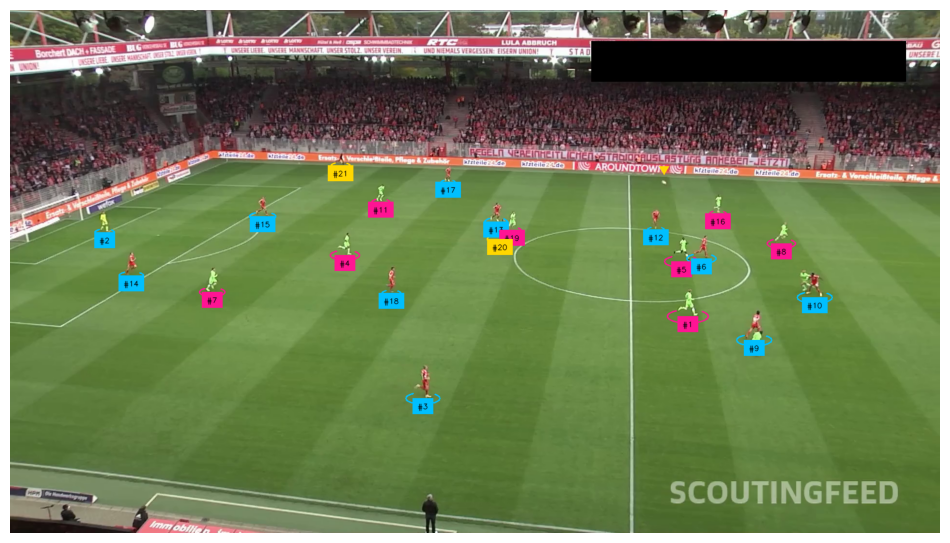

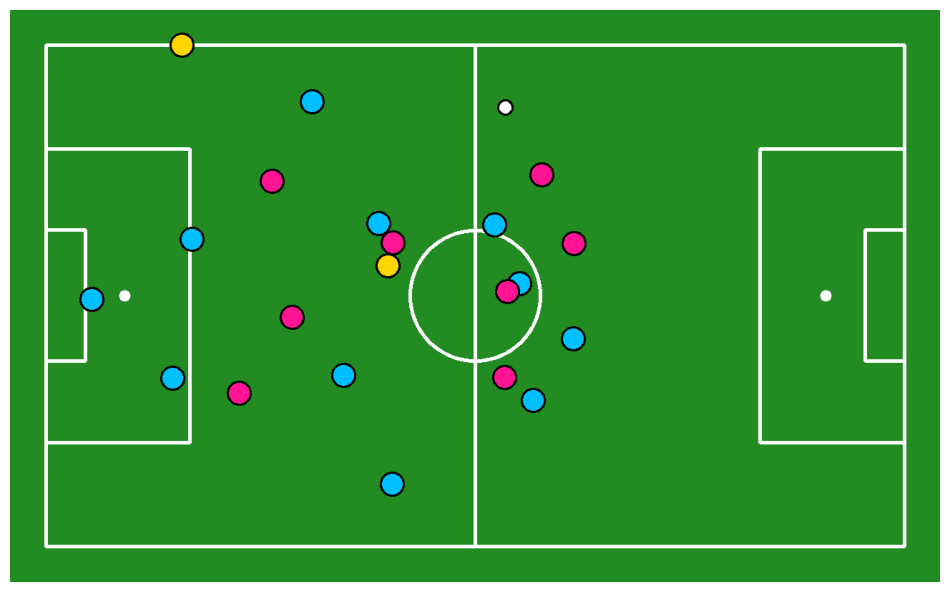

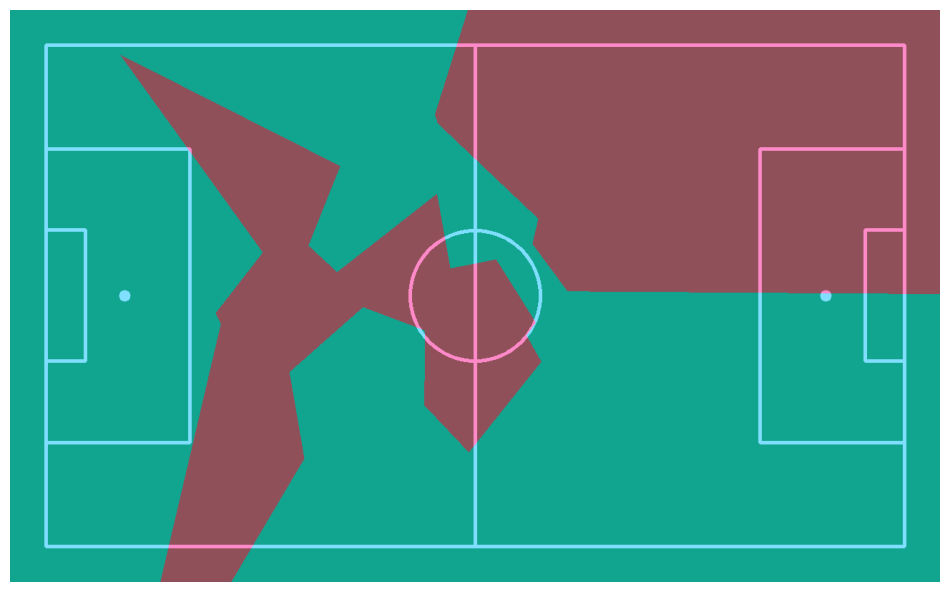

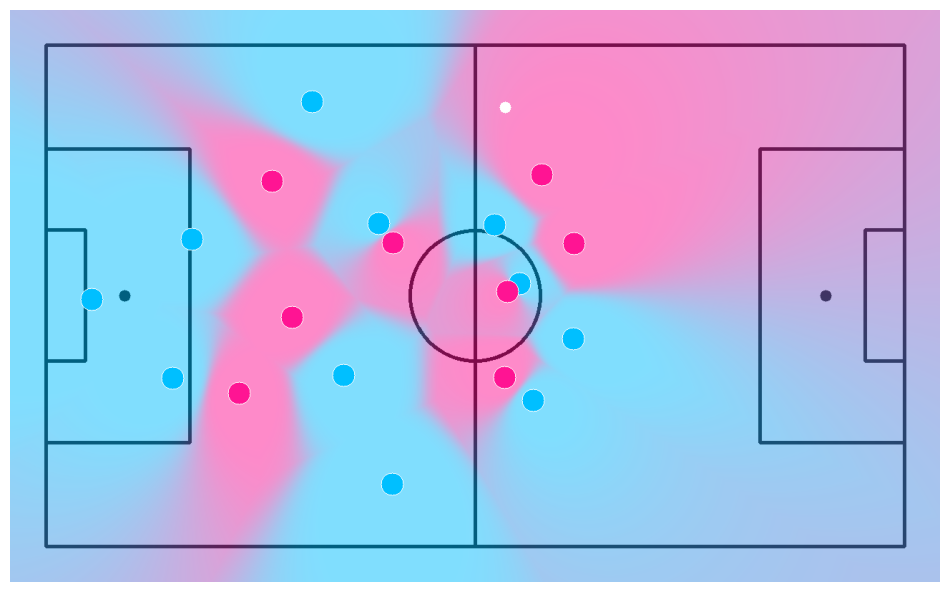

In [68]:
SOURCE_VIDEO_PATH = "/kaggle/working/121364_0.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# ball, goalkeeper, player, referee detection

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# team assignment

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])

# detect pitch key points

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# project ball, players and referies on pitch

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

# visualize video game-style radar view

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referees_xy,
    face_color=sv.Color.from_hex('FFD700'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_pitch_voronoi_diagram(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram with blend

annotated_frame = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)
annotated_frame = draw_pitch_voronoi_diagram_2(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.WHITE,
    radius=8,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [70]:
OUTPUT_VIDEO_PATH = "output_video.mp4"
TARGET_VIDEO_PATH = ""
# Annotators initialization
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

# Initialize tracker
tracker = sv.ByteTrack()
tracker.reset()

# Allows us to loop over frames of the video
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Keeping the same video attributes as the input video
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

with video_sink:
# Process each frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        # === Object detection and tracking on the original frame ===
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        
        # Process ball detections (with padding)
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        
        # Process remaining detections with non-max suppression and tracker update
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)
        
        # Separate detections by class
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]
        
        # Team assignment
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)
        
        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
            players_detections, goalkeepers_detections)
        
        referees_detections.class_id -= 1
        
        # Merge all detections for annotation
        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])
        
        # Create labels from tracker IDs
        labels = [f"#{tracker_id}" for tracker_id in all_detections.tracker_id]
        all_detections.class_id = all_detections.class_id.astype(int)
        
        # (Optional) First visualization: detection overlay
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame, detections=all_detections)
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=all_detections, labels=labels)
        annotated_frame = triangle_annotator.annotate(
            scene=annotated_frame, detections=ball_detections)
        # You could display this frame with sv.plot_image(annotated_frame)
        
        # === Field / pitch projection ===
        # Merge players and goalkeepers for pitch projection
        players_detections_merged = sv.Detections.merge([
            players_detections, goalkeepers_detections
        ])
        
        # Detect pitch key points
        result_field = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result_field)
        
        # Use key points with confidence > 0.5 to define correspondence
        filter_mask = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter_mask]
        pitch_reference_points = np.array(CONFIG.vertices)[filter_mask]
        
        # Compute the transformation from frame to pitch coordinates
        transformer = ViewTransformer(
            source=frame_reference_points,
            target=pitch_reference_points
        )
        
        # Get ball, players, and referees positions in frame coordinates
        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        players_xy = players_detections_merged.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        
        # Transform them to pitch coordinates
        pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)
        pitch_players_xy = transformer.transform_points(points=players_xy)
        pitch_referees_xy = transformer.transform_points(points=referees_xy)
        
        # === Final visualization: Voronoi diagram with blend ===
        annotated_pitch = draw_pitch(
            config=CONFIG,
            background_color=sv.Color.WHITE,
            line_color=sv.Color.BLACK
        )
        annotated_pitch = draw_pitch_voronoi_diagram_2(
            config=CONFIG,
            team_1_xy=pitch_players_xy[players_detections_merged.class_id == 0],
            team_2_xy=pitch_players_xy[players_detections_merged.class_id == 1],
            team_1_color=sv.Color.from_hex('00BFFF'),
            team_2_color=sv.Color.from_hex('FF1493'),
            pitch=annotated_pitch
        )
        annotated_pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.WHITE,
            radius=8,
            thickness=1,
            pitch=annotated_pitch
        )
        annotated_pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections_merged.class_id == 0],
            face_color=sv.Color.from_hex('00BFFF'),
            edge_color=sv.Color.WHITE,
            radius=16,
            thickness=1,
            pitch=annotated_pitch
        )
        annotated_pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_players_xy[players_detections_merged.class_id == 1],
            face_color=sv.Color.from_hex('FF1493'),
            edge_color=sv.Color.WHITE,
            radius=16,
            thickness=1,
            pitch=annotated_pitch
        )
        
        # For this example we take the final annotated pitch as our output frame.
        final_frame = annotated_pitch
    
        video_sink.write_frame(final_frame)

  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.88it/s]
  0%|          | 1/750 [00:01<12:41,  1.02s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.89it/s]
  0%|          | 2/750 [00:01<12:00,  1.04it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.90it/s]
  0%|          | 3/750 [00:02<11:46,  1.06it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.93it/s]
  1%|          | 4/750 [00:03<11:40,  1.07it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.83it/s]
  1%|          | 5/750 [00:04<11:40,  1.06it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.77it/s]
  1%|          | 6/750 [00:05<11:42,  1.06it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.83it/s]
  1%|          | 7/750 [00:06<11:38,  1.06it/s]
Embedding extraction: 